In [ ]:
# Install necessary dependencies if not already installed
!apt-get install -y poppler-utils
!pip install pytesseract transformers torch pdf2image pillow matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [ ]:
# Install Tesseract and required libraries
!apt-get update
!apt-get install -y tesseract-ocr libtesseract-dev
!apt-get install -y poppler-utils

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,435 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 1,692 kB in 2s (1,001 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Source

In [ ]:
!pip install pytesseract

In [ ]:
!apt-get update
!apt-get install -y poppler-utils

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [962 kB]
Ge

In [ ]:
import pytesseract
import torch
from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification
from PIL import Image
from pdf2image import convert_from_path
import pandas as pd

In [ ]:
# Install necessary dependencies if not already installed
!apt-get install -y poppler-utils
!pip install pytesseract transformers torch pdf2image pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [ ]:
# Google Colab environment does not require explicit path for Tesseract
# Set up Tesseract executable path for Colab
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Use the uploaded PDF path
pdf_path = "/content/Invoice_Sample.pdf"  # Replace with your PDF path if uploaded to Colab

In [ ]:
# Convert PDF to images
images = convert_from_path(pdf_path)


In [ ]:
# Initialize LayoutLMv2 Processor and Model with apply_ocr=False
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", apply_ocr=False) # Set apply_ocr to False
model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutlmv2-base-uncased")

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def extract_text_and_boxes(image):
    ocr_result = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    raw_text = pytesseract.image_to_string(image)
    words, boxes = [], []

    # Get image dimensions
    image_width, image_height = image.size

    # Extract words and bounding box coordinates
    for i in range(len(ocr_result["text"])):
        word = ocr_result["text"][i]
        if word.strip():
            x, y, w, h = ocr_result["left"][i], ocr_result["top"][i], ocr_result["width"][i], ocr_result["height"][i]
            # Normalize coordinates to fit within 0-1000 range
            x_norm = int(1000 * (x / image_width))
            y_norm = int(1000 * (y / image_height))
            w_norm = int(1000 * ((x + w) / image_width))
            h_norm = int(1000 * ((y + h) / image_height))
            words.append(word)
            boxes.append([x_norm, y_norm, w_norm, h_norm])

    return words, boxes, raw_text


In [ ]:
# Function to extract key fields using regex patterns from raw text
def extract_fields_from_text(raw_text):
    fields = {}

    # Define regex patterns for various fields
    patterns = {
        "Invoice Number": r"(?i)invoice\s*#?\s*[:\-\s]*([\w-]+)",
        "Date": r"(?i)(?:invoice date|date)\s*[:\-\s]*([\w\s,.-]+)",
        "From": r"(?i)from\s*[:\-\s]*([\w\s,.-]+)",
        "To": r"(?i)to\s*[:\-\s]*([\w\s,.-]+)",
        "Total Due": r"(?i)total\s*due\s*[:\-\s]*\$?([\d,\.]+)",
        "Total": r"(?i)total\s*[:\-\s]*\$?([\d,\.]+)",
        "Tax": r"(?i)tax\s*[:\-\s]*\$?([\d,\.]+)"
    }

    # Extract each field using regex patterns
    for field, pattern in patterns.items():
        match = re.search(pattern, raw_text)
        if match:
            fields[field] = match.group(1).strip()

    return fields


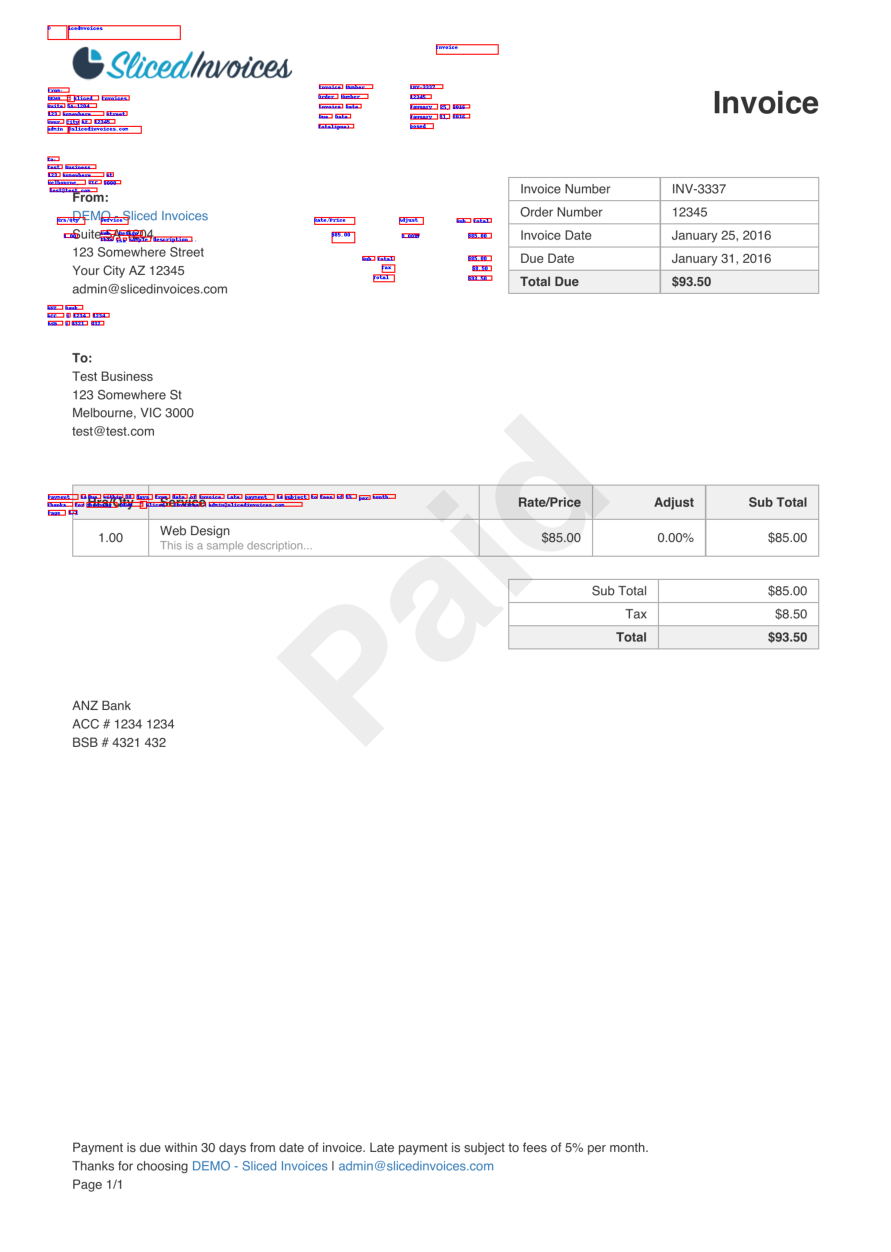


Raw OCR Text:
 © icedmvoices

From:
DEMO - Sliced Invoices

Invoice

 

Invoice Number

INV-3337

 

Order Number

12345

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

Suite 5A-1204 Invoice Date January 25, 2016
123 Somewhere Street Due Date January 31, 2016
Your City AZ 12345
admin @slicedinvoices.com fotalipue) posed
To:
Test Business
123 Somewhere St
Melbourne, VIC 3000
lest@test.com
Hrs/Qty Service Rate/Price Adjust Sub Total
Web Design 9
1.00 This is a sample description... $85.00 0.00% $85.00
Sub Total $85.00
Tax $8.50
Total $93.50

ANZ Bank
ACC # 1234 1234
BSB # 4321 432

Payment is due within 30 days from date of invoice. Late payment is subject to fees of 5% per month.
Thanks for choosing DEMO - Sliced Invoices | admin@slicedinvoices.com

Page 1/1

 

 

 

 


Extracted Fields:
Invoice Number: s
Date: January 25, 2016
123 Somewhere Street Due Date January 31, 2016
Your City AZ 12345
admin
From: DEMO - Sliced Invoices

Invoice

 

Invoice Number

INV-3337

 

Order Number


In [ ]:
# Function to visualize the extracted text and bounding boxes
def visualize_extracted_data(image, words, boxes):
    draw = ImageDraw.Draw(image)
    for word, box in zip(words, boxes):
        draw.rectangle([box[0], box[1], box[2], box[3]], outline="red", width=2)
        draw.text((box[0], box[1]), word, fill="blue")
    plt.figure(figsize=(12, 16))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Process each image and extract data
extracted_data = []
all_fields = {}
for img in images:
    words, boxes, raw_text = extract_text_and_boxes(img)

    # Visualize the extracted text and bounding boxes
    visualize_extracted_data(img.copy(), words, boxes)

    # Extract fields from the raw text
    fields = extract_fields_from_text(raw_text)
    all_fields.update(fields)

    # Debugging output to verify extracted raw text
    print("\nRaw OCR Text:\n", raw_text)

# Display extracted fields
print("\nExtracted Fields:")
for key, value in all_fields.items():
    print(f"{key}: {value}")